In [1]:
import tensorflow as tf
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from tqdm import tqdm
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import os
import importlib

In [2]:
# dir_r3 = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out'
dir_ml = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out'
randseed = 42
print("random seed: ", randseed)
np.random.seed(randseed)

def choose_data(dat, test_size, val_size):
    if dat == 'ml2':
        train = pd.read_csv(os.path.join(dir_ml, 'ml_train2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        test = pd.read_csv(os.path.join(dir_ml, 'ml_test2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        val = None  # Assuming no validation set for 'ml2'

        user_ids = train['userId'].unique()
        item_ids = train['songId'].unique()

        n_users = len(user_ids)
        n_items = len(item_ids)
    elif dat == 'ml':
        ml_full = pd.read_csv(os.path.join(dir_ml, 'ml-1m_full.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")

        # Get unique user IDs

        user_ids = ml_full['userId'].unique()
        item_ids = ml_full['songId'].unique()

        n_users = len(user_ids)
        n_items = len(item_ids)
        # Split user IDs for train, validation, and test sets
        train, test = train_test_split(ml_full, test_size=test_size, random_state=42)
        train, val = train_test_split(train, test_size=val_size/(1-test_size), random_state=42)

    else:
        print('Wrong data input')
        return None, None, None

    # Print the sizes of the datasets
    print(f"Train set size: {train.shape[0]} ratings")
    # print(f"Validation set size: {val.shape[0] if val is not None else 0} ratings")
    print(f"Test set size: {test.shape[0]} ratings")
    # print(ml_full.shape[0])
    # print(train.shape[0] + val.shape[0] +  test.shape[0])

    return train, test, val,  n_users, n_items

def load_confounders(dat, k):# contype):
    CAUSEFIT_DIR = f'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/exposure_output/{dat}_exp_k_{k}.csv'
    conf_df = pd.read_csv(CAUSEFIT_DIR, header=None)
    confounder_data = conf_df.to_numpy().T
    return confounder_data


def load_data_rating(dat, columns=[0, 1, 2], sep="\t", include_validation=False, test_size=0.1, val_size=0.1):
    train, val, test, n_users, n_items = choose_data(dat, test_size, val_size)

    if train is None or test is None:
        return None, None, None, None, None

    if include_validation:
        # Use the provided validation set
        vad = val
    else:
        # Merge train and validation sets if validation is not required, and sort by userId
        train = pd.concat([train, val]).sort_values(by='userId').reset_index(drop=True)
        vad = None

    def build_matrix(df):
        rows = []
        cols = []
        ratings = []
        for line in df.itertuples():
            rows.append(line[1])
            cols.append(line[2])
            ratings.append(line[3])
        return csr_matrix((ratings, (rows, cols)), shape=(n_users, n_items)).todok()

    train_matrix = build_matrix(train)
    test_matrix = build_matrix(test)
    vad_matrix = build_matrix(vad) if vad is not None else None

    print("Load data finished. Number of users:", n_users, "Number of items:", n_items)
    return train_matrix, test_matrix, vad_matrix, n_users, n_items






random seed:  42


In [18]:
def run_model(module_name, class_name, k, dat='ml', include_validation=False, use_confounder=False, use_exposure=False, test_size=0.1, val_size=0.1, 
              hidden_neuron=500, learning_rate=0.001, reg_rate=0.1, epoch=20, batch_size=200, verbose=False, T=1, display_step=1000, save_path=None):
    
    train, test, vad, user, item = load_data_rating(dat, columns=[0, 1, 2], sep="\t", include_validation=include_validation, test_size=test_size, val_size=val_size)

    confounder_data = None
    exposure_data = None

    if use_confounder:
        # Load confounder data
        confounder_data = load_confounders(dat, k)
    if use_exposure:
        # Create exposure matrix
        exposure_data = (train > 0).astype(np.float32).todense().T
    
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True

    with tf.compat.v1.Session(config=config) as sess:
        # Dynamically import the module and create an instance of the chosen class
        module = importlib.import_module(module_name)
        model_class = getattr(module, class_name)
        final_model = model_class(sess, user, item, learning_rate=learning_rate, reg_rate=reg_rate, epoch=epoch, batch_size=batch_size, verbose=verbose, T=T, display_step=display_step)

        final_model.build_network(hidden_neuron=hidden_neuron)
        
        # Determine how many arguments to pass to the execute function
        if confounder_data is not None and exposure_data is not None:
            final_model.execute(train, test, confounder_data, exposure_data)
        elif confounder_data is not None:
            final_model.execute(train, test, confounder_data)
        else:
            final_model.execute(train, test)

        # Save the training and test RMSE values
        if save_path:
            class_folder = os.path.join(save_path, class_name.lower())
            os.makedirs(class_folder, exist_ok=True)

            train_loss_file = os.path.join(class_folder, f'{epoch}_TUNED_train_loss_{dat}_k{k}.npy')
            test_rmse_file = os.path.join(class_folder, f'{epoch}_TUNED_test_rmse_{dat}_k{k}.npy')
            # final_rmse_file = os.path.join(class_folder, f'{contype}_256final_rmse_{dat}_k{k}.npy')
            # final_mae_file = os.path.join(class_folder, f'{contype}_256final_mae_{dat}_k{k}.npy')

            np.save(train_loss_file, np.array(final_model.train_loss_history))
            np.save(test_rmse_file, np.array(final_model.test_rmse_history))

            if confounder_data is not None and exposure_data is not None:
                final_rmse, final_mae = final_model.test(test, confounder_data, exposure_data)
            elif confounder_data is not None:
                final_rmse, final_mae = final_model.test(test, confounder_data)
            else:
                final_rmse, final_mae = final_model.test(test)

            # np.save(final_rmse_file, np.array(final_rmse))
            # np.save(final_mae_file, np.array(final_mae))

        print(f"Final RMSE: {final_rmse}, Final MAE: {final_mae}")


def run_all_models(result_path, models, k_values):
    # for c in contype:
        for k in k_values:
            for model in models:
                use_confounder = 'conf' in model['module_name']
                use_exposure = 'exp' in model['module_name']
                
                print(f"Running {model['class_name']} with k={k}, use_confounder={use_confounder}, use_exposure={use_exposure}")
                run_model(model['module_name'], model['class_name'], k, dat='ml', include_validation=False, use_confounder=use_confounder, use_exposure=use_exposure, test_size=0.1, val_size=0.1, hidden_neuron=500, 
                        learning_rate=0.001, reg_rate=1, epoch=170, batch_size=512, verbose=True, save_path=result_path)
                
                print(f"Completed {model['class_name']} with k={k}")

# Best parameters for UAutoRec2confexp in detailed form for 10 folds, early stopping 15 evaluations wiht 150 epochs: {'learning_rate': 0.0007588485431339859, 'reg_rate': 0.0964568931104186, 'hidden_neuron': 500, 'k': 100}


In [20]:
result_path = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/results'

models = [
    {'module_name': 'urec_og', 'class_name': 'UAutoRec'},
    {'module_name': 'urec_1_conf', 'class_name': 'UAutoRec1conf'},
    {'module_name': 'urec_1_confexp', 'class_name': 'UAutoRec1confexp'},
    {'module_name': 'urec_2_conf', 'class_name': 'UAutoRec2conf'},
    {'module_name': 'urec_2_confexp', 'class_name': 'UAutoRec2confexp'},
    # {'module_name': 'urec_2_confexp copy', 'class_name': 'UAutoRec2confexpcopy'}
    {'module_name': 'urec_3_conf', 'class_name': 'UAutoRec3conf'},
    {'module_name': 'urec_3_confexp', 'class_name': 'UAutoRec3confexp'},
    {'module_name': 'urec_4_conf', 'class_name': 'UAutoRec4conf'},
    {'module_name': 'urec_4_confexp', 'class_name': 'UAutoRec4confexp'}
]

k_values = [32]
contype = ['hpf']


run_all_models(result_path, models, k_values)


Running UAutoRec with k=32, use_confounder=False, use_exposure=False
Train set size: 800169 ratings
Test set size: 100022 ratings
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec.


Training: 100%|██████████| 170/170 [10:50<00:00,  3.83s/epoch, Loss=3.99e+4, RMSE=0.874, MAE=0.692]


Final RMSE: 0.8739841610059013, Final MAE: 0.6923886498412405
Completed UAutoRec with k=32
Running UAutoRec1conf with k=32, use_confounder=True, use_exposure=False
Train set size: 800169 ratings
Test set size: 100022 ratings
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec with Confounder.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 170/170 [13:30<00:00,  4.76s/epoch, Loss=1.87e+4, RMSE=0.942, MAE=0.753]


Final RMSE: 0.9421317859768349, Final MAE: 0.7528979569489915
Completed UAutoRec1conf with k=32
Running UAutoRec1confexp with k=32, use_confounder=True, use_exposure=True
Train set size: 800169 ratings
Test set size: 100022 ratings
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec with Confounder and Exposure.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 170/170 [15:39<00:00,  5.53s/epoch, Loss=1.78e+4, RMSE=0.966, MAE=0.772]


Final RMSE: 0.9661304947873842, Final MAE: 0.7718788514588772
Completed UAutoRec1confexp with k=32
Running UAutoRec2conf with k=32, use_confounder=True, use_exposure=False
Train set size: 800169 ratings
Test set size: 100022 ratings
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec with Confounder.


Training: 100%|██████████| 170/170 [13:23<00:00,  4.72s/epoch, Loss=3.96e+4, RMSE=0.871, MAE=0.69] 


Final RMSE: 0.8712343633448107, Final MAE: 0.6901204938096203
Completed UAutoRec2conf with k=32
Running UAutoRec2confexp with k=32, use_confounder=True, use_exposure=True
Train set size: 800169 ratings
Test set size: 100022 ratings
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec with Confounder and Exposure.


Training:  79%|███████▉  | 135/170 [12:39<03:16,  5.63s/epoch, Loss=4.35e+4, RMSE=0.861, MAE=0.681]


Early stopping at epoch 135. Best RMSE: 0.8571804680059727
Final RMSE: 0.8612354703497834, Final MAE: 0.6807242407804698
Completed UAutoRec2confexp with k=32
Running UAutoRec3conf with k=32, use_confounder=True, use_exposure=False
Train set size: 800169 ratings
Test set size: 100022 ratings
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec with Confounder.


Training: 100%|██████████| 170/170 [12:23<00:00,  4.38s/epoch, Loss=4.5e+4, RMSE=0.867, MAE=0.686] 


Final RMSE: 0.8667847796188008, Final MAE: 0.6863752863900032
Completed UAutoRec3conf with k=32
Running UAutoRec3confexp with k=32, use_confounder=True, use_exposure=True
Train set size: 800169 ratings
Test set size: 100022 ratings
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 170/170 [13:15<00:00,  4.68s/epoch, Loss=4.6e+4, RMSE=0.867, MAE=0.686] 


Final RMSE: 0.8674555430398726, Final MAE: 0.686290804945295
Completed UAutoRec3confexp with k=32
Running UAutoRec4conf with k=32, use_confounder=True, use_exposure=False
Train set size: 800169 ratings
Test set size: 100022 ratings
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec with Confounder.


Training: 100%|██████████| 170/170 [21:12<00:00,  7.49s/epoch, Loss=2.53e+4, RMSE=0.942, MAE=0.749]


Final RMSE: 0.9422048071156847, Final MAE: 0.7494242211068907
Completed UAutoRec4conf with k=32
Running UAutoRec4confexp with k=32, use_confounder=True, use_exposure=True
Train set size: 800169 ratings
Test set size: 100022 ratings
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 170/170 [31:34<00:00, 11.14s/epoch, Loss=1e+4, RMSE=1.04, MAE=0.828]   


Final RMSE: 1.0394621999948022, Final MAE: 0.8275074259346781
Completed UAutoRec4confexp with k=32


Files for uautorec with k=32 not found.
Files for uautorec2confexp with k=32 not found.
Files for uautorec with k=100 not found.
uautorec2confexp (k=100) - Train loss history shape: (193,)
uautorec2confexp (k=100) - Test RMSE history shape: (193,)


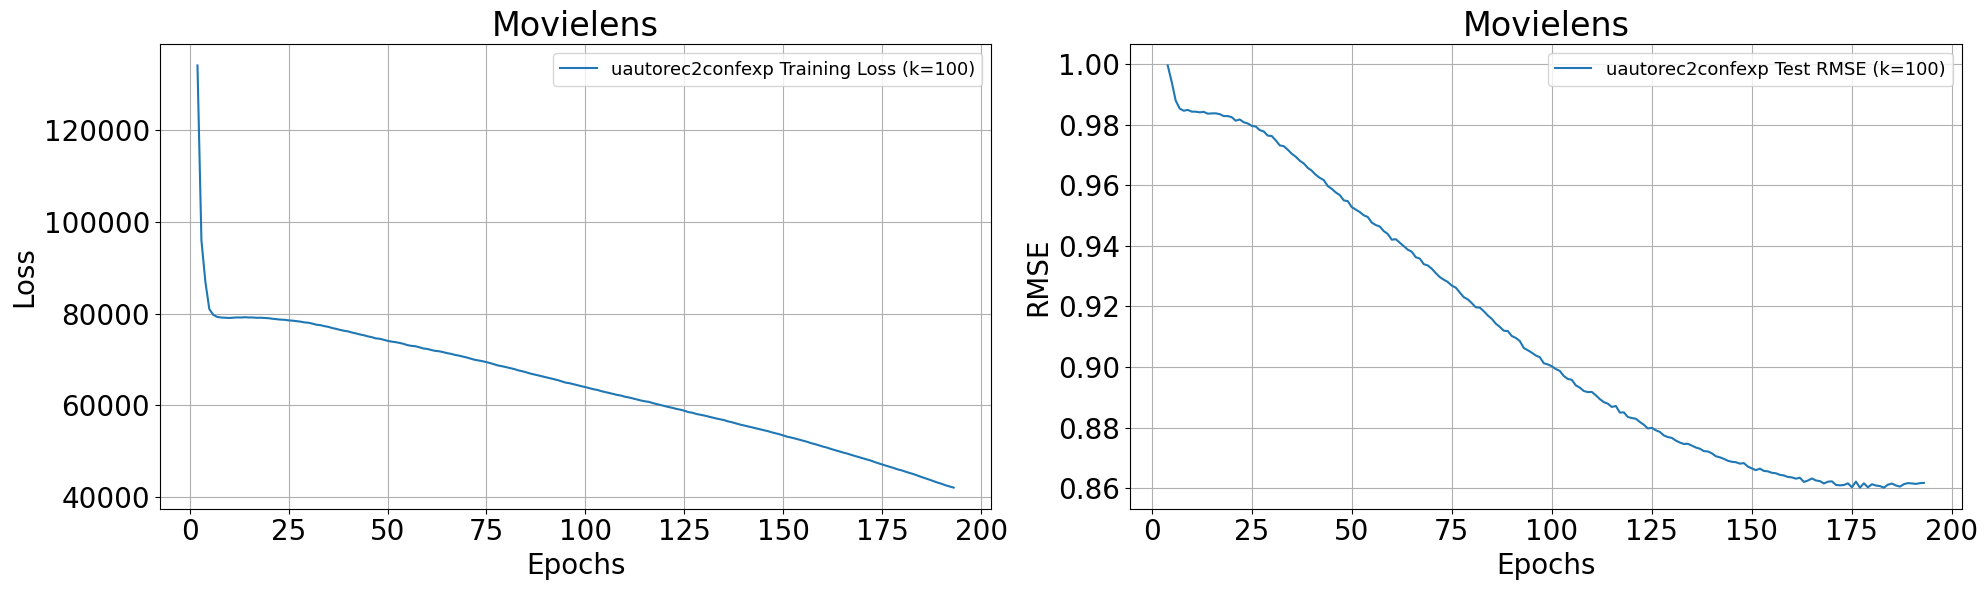

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_results(result_path, models, k_values, contype):
    epoch = 200
    plt.figure(figsize=(20, 6))

    for c in contype:
        for k in k_values:
            for model in models:
                class_name = model['class_name'].lower()
                class_folder = os.path.join(result_path, class_name)
                train_loss_file = os.path.join(class_folder, f'{epoch}_TUNED_train_loss_ml_k{k}.npy')
                test_rmse_file = os.path.join(class_folder, f'{epoch}_TUNED_test_rmse_ml_k{k}.npy')

                if not os.path.exists(train_loss_file) or not os.path.exists(test_rmse_file):
                    print(f"Files for {class_name} with k={k} not found.")
                    continue

                train_loss_history = np.load(train_loss_file)
                test_rmse_history = np.load(test_rmse_file)

                print(f"{class_name} (k={k}) - Train loss history shape: {train_loss_history.shape}")
                print(f"{class_name} (k={k}) - Test RMSE history shape: {test_rmse_history.shape}")

                epochs = np.arange(1, len(train_loss_history) + 1)

                # Plot training loss
                plt.subplot(1, 2, 1)
                plt.plot(epochs[1:], train_loss_history[1:], label=f'{class_name} Training Loss (k={k})')
                
                # Plot test RMSE
                plt.subplot(1, 2, 2)
                plt.plot(epochs[3:], test_rmse_history[3:], label=f'{class_name} Test RMSE (k={k})')


    plt.subplot(1, 2, 1)
    plt.xlabel('Epochs', fontsize = 20)
    plt.ylabel('Loss', fontsize = 20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('Movielens', fontsize = 24)
    plt.legend(fontsize = 13)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.xlabel('Epochs', fontsize = 20)
    plt.ylabel('RMSE', fontsize = 20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('Movielens', fontsize = 24)
    plt.legend(fontsize = 13)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
result_path = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/results'
models = [
    {'module_name': 'urec_og', 'class_name': 'UAutoRec'},
    # {'module_name': 'urec_1_conf', 'class_name': 'UAutoRec1Conf'},
    # {'module_name': 'urec_1_confexp', 'class_name': 'UAutoRec1ConfExp'},
    # {'module_name': 'urec_2_conf', 'class_name': 'UAutoRec2Conf'},
    {'module_name': 'urec_2_confexp', 'class_name': 'UAutoRec2ConfExp'},
    # {'module_name': 'urec_3_conf', 'class_name': 'UAutoRec3Conf'},
    # {'module_name': 'urec_3_confexp', 'class_name': 'UAutoRec3ConfExp'},
    # {'module_name': 'urec_4_conf', 'class_name': 'UAutoRec4Conf'},
    # {'module_name': 'urec_4_confexp', 'class_name': 'UAutoRec4ConfExp'}
]
k_values = [32, 100]  # Add all the k values you want to plot
contype = ['hpf']
tuned = ['TUNED', '']
plot_results(result_path, models, k_values, contype)

In [15]:
import os
import numpy as np
import pandas as pd

def load_rmse_history(result_path, models, k_values):#, contype):
    results = []
    epoch = 200
    # for c in contype:
    for k in k_values:
        for model in models:
            class_name = model['class_name'].lower()
            class_folder = os.path.join(result_path, class_name)
            test_rmse_file = os.path.join(class_folder, f'{epoch}_TUNED_test_rmse_ml_k{k}.npy')

            if not os.path.exists(test_rmse_file):
                print(f"Test RMSE file for {class_name} with k={k} not found.")
                continue

            test_rmse_history = np.load(test_rmse_file)
            final_rmse = test_rmse_history[-10]  # Last RMSE value
            best_rmse = np.min(test_rmse_history)  # Lowest RMSE value

            results.append({
                'Model': model['class_name'],
                'k': k,
                'Final RMSE': final_rmse,
                'Best RMSE': best_rmse
                # 'c': c
            })

    return pd.DataFrame(results)

# Example usage
result_path = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/results'

models = [
    # {'module_name': 'urec_og', 'class_name': 'UAutoRec'},
    # {'module_name': 'urec_1_conf', 'class_name': 'UAutoRec1conf'},
    # {'module_name': 'urec_1_confexp', 'class_name': 'UAutoRec1confexp'},
    # {'module_name': 'urec_2_conf', 'class_name': 'UAutoRec2conf'},
    {'module_name': 'urec_2_confexp', 'class_name': 'UAutoRec2confexp'},
    # {'module_name': 'urec_3_conf', 'class_name': 'UAutoRec3conf'},
    # {'module_name': 'urec_3_confexp', 'class_name': 'UAutoRec3confexp'},
    # {'module_name': 'urec_4_conf', 'class_name': 'UAutoRec4conf'},
    # {'module_name': 'urec_4_confexp', 'class_name': 'UAutoRec4confexp'}
]
k_values = [32]
contype = ['hpf']
results_df = load_rmse_history(result_path, models, k_values)#, contype)
print(results_df)

# Save the results to a CSV file if needed
# results_csv_file = os.path.join(result_path, 'rmse_results.csv')
# results_df.to_csv(results_csv_file, index=False)


Test RMSE file for uautorec1conf with k=32 not found.
Test RMSE file for uautorec1confexp with k=32 not found.
              Model   k  Final RMSE  Best RMSE
0          UAutoRec  32    0.878204   0.867935
1  UAutoRec2confexp  32    0.871340   0.862811
2  UAutoRec3confexp  32    0.871191   0.867774


Test RMSE file for uautorec with k=100 not found.
               Model    k          Final RMSE  Best RMSE
0           UAutoRec   32  0.8951881399552926   0.895188
1      UAutoRec1conf   32  0.8709157246374017   0.870916
2   UAutoRec1confexp   32  0.8853822227308931   0.870422
3      UAutoRec2conf   32  0.8973961016530623   0.897396
4   UAutoRec2confexp   32  0.8804192385313928   0.880419
5      UAutoRec3conf   32  0.8975423166217638   0.897466
6   UAutoRec3confexp   32  0.8931277080242566   0.893128
7      UAutoRec4conf   32  0.9298756286976327   0.929436
8   UAutoRec4confexp   32  1.0551527760104047   0.989415
9      UAutoRec1conf  100  0.8714670816791393   0.871467
10  UAutoRec1confexp  100  0.8850846907175748   0.870266
11     UAutoRec2conf  100  0.8959809479822212   0.895981
12  UAutoRec2confexp  100  0.8817742320017419   0.881774
13     UAutoRec3conf  100  0.8963843228736388   0.896384
14  UAutoRec3confexp  100  0.8949812720954456   0.894981
15     UAutoRec4conf  100  0.928213117